In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import seaborn as sns
import random

Para el desarrollo del proyecto, decidí hacer uso únicamente de 3 de los 7 archivos que estaban disponibles.

El primero es steam.csv, el cual incluye información general de los juegos, como el nombre, fecha de lanzamiento, cantidad de ratings positivos y negativos, precio, etc. También cuenta con una columna de categorías, la cual tuve que tratar para extraer su información en varias columnas.

Después de tratar este archivo, lo junté con el archivo steamspy_tag_data.csv, el cual cuenta con información acerca de los géneros de los juegos. A cada juego se le asigna un valor por cada género. Un valor más alto indica que un juego está más relacionado a un género. Dado a que existían muchísimos géneros, decidí extraer los géneros más relevantes, es decir, los que están más presentes en los juegos.

Una vez que tenía una tabla con las características más importantes de los juegos, los convertí en una matriz de similitud. Esta matriz tiene los nombres de los juegos tanto en las filas como en las columnas, y el valor de cada celda indica qué tanto se parece un juego a otro. Esto quiere decir que, mientras dos juegos que se parezcan más entre sí, el valor se va a acercar a 1.

De esta manera, podemos utilizar los datos para encontrar similitudes entre los juegos, y crear un sistema de recomendación que sea capaz de encontrar juegos similares a los que un usuario juega.

In [2]:
games_df = pd.read_csv("steam_data/steam.csv")
games_df.head()

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,124534,3339,17612,317,10000000-20000000,7.19
1,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,3318,633,277,62,5000000-10000000,3.99
2,30,Day of Defeat,2003-05-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Valve Anti-Cheat enabled,Action,FPS;World War II;Multiplayer,0,3416,398,187,34,5000000-10000000,3.99
3,40,Deathmatch Classic,2001-06-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,1273,267,258,184,5000000-10000000,3.99
4,50,Half-Life: Opposing Force,1999-11-01,1,Gearbox Software,Valve,windows;mac;linux,0,Single-player;Multi-player;Valve Anti-Cheat en...,Action,FPS;Action;Sci-fi,0,5250,288,624,415,5000000-10000000,3.99


In [3]:
games_df = games_df.drop_duplicates(subset='name')

In [4]:
games_df['name']

0                    Counter-Strike
1             Team Fortress Classic
2                     Day of Defeat
3                Deathmatch Classic
4         Half-Life: Opposing Force
                    ...            
27070               Room of Pandora
27071                     Cyber Gun
27072              Super Star Blast
27073    New Yankee 7: Deer Hunters
27074                     Rune Lord
Name: name, Length: 27033, dtype: object

In [5]:
games_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27033 entries, 0 to 27074
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   appid             27033 non-null  int64  
 1   name              27033 non-null  object 
 2   release_date      27033 non-null  object 
 3   english           27033 non-null  int64  
 4   developer         27033 non-null  object 
 5   publisher         27033 non-null  object 
 6   platforms         27033 non-null  object 
 7   required_age      27033 non-null  int64  
 8   categories        27033 non-null  object 
 9   genres            27033 non-null  object 
 10  steamspy_tags     27033 non-null  object 
 11  achievements      27033 non-null  int64  
 12  positive_ratings  27033 non-null  int64  
 13  negative_ratings  27033 non-null  int64  
 14  average_playtime  27033 non-null  int64  
 15  median_playtime   27033 non-null  int64  
 16  owners            27033 non-null  object

In [6]:
games_df['owners'].unique()

array(['10000000-20000000', '5000000-10000000', '2000000-5000000',
       '20000000-50000000', '100000000-200000000', '50000000-100000000',
       '20000-50000', '500000-1000000', '100000-200000', '50000-100000',
       '1000000-2000000', '200000-500000', '0-20000'], dtype=object)

In [7]:
max_owners = games_df['owners'].str.split('-', expand=True).astype(int)[1]
label_encoder = LabelEncoder()
games_df['owners_encoded'] = label_encoder.fit_transform(max_owners)
games_df = games_df.drop(columns=['owners'], axis=1)

In [8]:
game_features = games_df['categories'].str.split(';').explode().value_counts()
irrelevant_features = game_features[game_features < 95].index.to_list()
irrelevant_features

['Valve Anti-Cheat enabled',
 'Steam Turn Notifications',
 'SteamVR Collectibles',
 'Includes Source SDK',
 'Mods',
 'Mods (require HL2)']

In [9]:
games_df['categories'] = games_df['categories'].str.split(';')
dummies = pd.get_dummies(games_df['categories'].apply(pd.Series).stack(), prefix='ftr').groupby(level=0).sum()
games_df = pd.concat([games_df, dummies], axis=1)

In [10]:
irrelevant_features = ['ftr_' + feature for feature in irrelevant_features]
games_df = games_df.drop(irrelevant_features, axis=1)
games_df = games_df.drop(['platforms','categories','genres','steamspy_tags','achievements','developer'], axis=1)


In [11]:
from datetime import datetime
release_year = [datetime.strptime(date, '%Y-%m-%d').year for date in games_df['release_date']]
games_df['release_date'] = release_year

In [12]:
games_df.head()

,appid,name,release_date,english,publisher,required_age,positive_ratings,negative_ratings,average_playtime,median_playtime,...,ftr_Partial Controller Support,ftr_Shared/Split Screen,ftr_Single-player,ftr_Stats,ftr_Steam Achievements,ftr_Steam Cloud,ftr_Steam Leaderboards,ftr_Steam Trading Cards,ftr_Steam Workshop,ftr_VR Support
0,10,Counter-Strike,2000,1,Valve,0,124534,3339,17612,317,...,0,0,0,0,0,0,0,0,0,0
1,20,Team Fortress Classic,1999,1,Valve,0,3318,633,277,62,...,0,0,0,0,0,0,0,0,0,0
2,30,Day of Defeat,2003,1,Valve,0,3416,398,187,34,...,0,0,0,0,0,0,0,0,0,0
3,40,Deathmatch Classic,2001,1,Valve,0,1273,267,258,184,...,0,0,0,0,0,0,0,0,0,0
4,50,Half-Life: Opposing Force,1999,1,Valve,0,5250,288,624,415,...,0,0,1,0,0,0,0,0,0,0


In [13]:
games_df['publisher'] = games_df['publisher'].str.split(';', expand=True)[0]

In [14]:
popular_publishers = games_df[games_df['owners_encoded'] >= 6]['publisher'].value_counts()
popular_publishers = popular_publishers[popular_publishers >= 3].index.to_list()

In [15]:
games_df['publisher_dummies'] = games_df['publisher'].apply(lambda x: x if x in popular_publishers else None)
games_df = pd.get_dummies(games_df, columns=['publisher_dummies'], prefix='pub')
games_df = games_df.drop(columns=['publisher'], axis=1)

In [16]:
tags_df = pd.read_csv('steam_data/steamspy_tag_data.csv')

In [17]:
non_zero = (tags_df > 0).sum().sort_values(ascending=False)

In [18]:
relevant_categories = non_zero[non_zero >= 100].index.to_list()
tags_df = tags_df[relevant_categories]

In [19]:
games_df = games_df.merge(tags_df, how='left', on="appid")
games_df.head()

,appid,name,release_date,english,required_age,positive_ratings,negative_ratings,average_playtime,median_playtime,price,...,hex_grid,time_management,runner,naval,strategy_rpg,tactical_rpg,science,alternate_history,narration,psychedelic
0,10,Counter-Strike,2000,1,0,124534,3339,17612,317,7.19,...,0,0,0,0,0,0,0,0,0,0
1,20,Team Fortress Classic,1999,1,0,3318,633,277,62,3.99,...,0,0,0,0,0,0,0,0,0,0
2,30,Day of Defeat,2003,1,0,3416,398,187,34,3.99,...,0,0,0,0,0,0,0,0,0,0
3,40,Deathmatch Classic,2001,1,0,1273,267,258,184,3.99,...,0,0,0,0,0,0,0,0,0,0
4,50,Half-Life: Opposing Force,1999,1,0,5250,288,624,415,3.99,...,0,0,0,0,0,0,0,0,0,0


In [20]:
exclude = ['appid', 'name']
feature_columns = [x for x in games_df.columns if x not in exclude]
games_df_numerical = games_df[feature_columns]
games_df_numerical

,release_date,english,required_age,positive_ratings,negative_ratings,average_playtime,median_playtime,price,owners_encoded,ftr_Captions available,...,hex_grid,time_management,runner,naval,strategy_rpg,tactical_rpg,science,alternate_history,narration,psychedelic
0,2000,1,0,124534,3339,17612,317,7.19,9,0,...,0,0,0,0,0,0,0,0,0,0
1,1999,1,0,3318,633,277,62,3.99,8,0,...,0,0,0,0,0,0,0,0,0,0
2,2003,1,0,3416,398,187,34,3.99,8,0,...,0,0,0,0,0,0,0,0,0,0
3,2001,1,0,1273,267,258,184,3.99,8,0,...,0,0,0,0,0,0,0,0,0,0
4,1999,1,0,5250,288,624,415,3.99,8,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27028,2019,1,0,3,0,0,0,2.09,0,0,...,0,0,0,0,0,0,0,0,0,0
27029,2019,1,0,8,1,0,0,1.69,0,0,...,0,0,0,0,0,0,0,0,0,0
27030,2019,1,0,0,1,0,0,3.99,0,0,...,0,0,0,0,0,0,0,0,0,0
27031,2019,1,0,2,0,0,0,5.19,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
scaler = StandardScaler()
games_df_scaled = pd.DataFrame(scaler.fit_transform(games_df_numerical), index=games_df['name'], columns=games_df.columns[2:])
games_df_scaled

,release_date,english,required_age,positive_ratings,negative_ratings,average_playtime,median_playtime,price,owners_encoded,ftr_Captions available,...,hex_grid,time_management,runner,naval,strategy_rpg,tactical_rpg,science,alternate_history,narration,psychedelic
name,,,,,,,,,,,,,,,,,,,,,
Counter-Strike,-7.644683,0.138667,-0.147625,6.500627,0.729370,9.550339,0.072475,0.140664,5.372167,-0.165417,...,-0.021115,-0.05189,-0.04833,-0.028406,-0.039232,-0.042034,-0.016451,-0.023349,-0.020213,-0.02187
Team Fortress Classic,-8.108100,0.138667,-0.147625,0.121872,0.098333,0.069443,-0.035775,-0.265489,4.716064,-0.165417,...,-0.021115,-0.05189,-0.04833,-0.028406,-0.039232,-0.042034,-0.016451,-0.023349,-0.020213,-0.02187
Day of Defeat,-6.254430,0.138667,-0.147625,0.127029,0.043531,0.020220,-0.047662,-0.265489,4.716064,-0.165417,...,-0.021115,-0.05189,-0.04833,-0.028406,-0.039232,-0.042034,-0.016451,-0.023349,-0.020213,-0.02187
Deathmatch Classic,-7.181265,0.138667,-0.147625,0.014258,0.012982,0.059052,0.016015,-0.265489,4.716064,-0.165417,...,-0.021115,-0.05189,-0.04833,-0.028406,-0.039232,-0.042034,-0.016451,-0.023349,-0.020213,-0.02187
Half-Life: Opposing Force,-8.108100,0.138667,-0.147625,0.223539,0.017879,0.259225,0.114077,-0.265489,4.716064,-0.165417,...,-0.021115,-0.05189,-0.04833,-0.028406,-0.039232,-0.042034,-0.016451,-0.023349,-0.020213,-0.02187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Room of Pandora,1.160249,0.138667,-0.147625,-0.052574,-0.049282,-0.082054,-0.062095,-0.506643,-0.532761,-0.165417,...,-0.021115,-0.05189,-0.04833,-0.028406,-0.039232,-0.042034,-0.016451,-0.023349,-0.020213,-0.02187
Cyber Gun,1.160249,0.138667,-0.147625,-0.052311,-0.049049,-0.082054,-0.062095,-0.557412,-0.532761,-0.165417,...,-0.021115,-0.05189,-0.04833,-0.028406,-0.039232,-0.042034,-0.016451,-0.023349,-0.020213,-0.02187
Super Star Blast,1.160249,0.138667,-0.147625,-0.052732,-0.049049,-0.082054,-0.062095,-0.265489,-0.532761,-0.165417,...,-0.021115,-0.05189,-0.04833,-0.028406,-0.039232,-0.042034,-0.016451,-0.023349,-0.020213,-0.02187


In [22]:
games_similarity_matrix = pd.DataFrame(cosine_similarity(games_df_scaled, games_df_scaled),
                                 index=games_df['name'],
                                 columns=games_df['name'])

In [23]:
games_similarity_matrix

name,Counter-Strike,Team Fortress Classic,Day of Defeat,Deathmatch Classic,Half-Life: Opposing Force,Ricochet,Half-Life,Counter-Strike: Condition Zero,Half-Life: Blue Shift,Half-Life 2,...,12 HOURS,The Mystery of Bikini Island,CaptainMarlene,Old Edge II,Deatherem,Room of Pandora,Cyber Gun,Super Star Blast,New Yankee 7: Deer Hunters,Rune Lord
name,,,,,,,,,,,,,,,,,,,,,
Counter-Strike,1.000000,0.578915,0.223866,0.217381,0.496110,0.211199,0.707775,0.271384,0.387550,0.221833,...,-0.067003,-0.077428,-0.057713,-0.086118,-0.091047,-0.093471,-0.009152,-0.031346,-0.077845,-0.077843
Team Fortress Classic,0.578915,1.000000,0.820544,0.833414,0.876250,0.793927,0.608012,0.823693,0.860837,0.273768,...,-0.128919,-0.147852,-0.110240,-0.163418,-0.185362,-0.190137,-0.071289,-0.062300,-0.155947,-0.155947
Day of Defeat,0.223866,0.820544,1.000000,0.961798,0.859168,0.912582,0.357002,0.965202,0.909489,0.271425,...,-0.102935,-0.109026,-0.087840,-0.119562,-0.144859,-0.149902,-0.059451,-0.045844,-0.120434,-0.120434
Deathmatch Classic,0.217381,0.833414,0.961798,1.000000,0.849125,0.914929,0.351585,0.949128,0.899819,0.261662,...,-0.133673,-0.140669,-0.111880,-0.154974,-0.180725,-0.185861,-0.081232,-0.059353,-0.151146,-0.151146
Half-Life: Opposing Force,0.496110,0.876250,0.859168,0.849125,1.000000,0.808772,0.738940,0.880581,0.973269,0.383356,...,-0.116542,-0.122214,-0.095882,-0.134816,-0.158302,-0.160096,-0.057794,-0.051759,-0.131799,-0.131799
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Room of Pandora,-0.093471,-0.190137,-0.149902,-0.185861,-0.160096,-0.180198,-0.115650,-0.147886,-0.139799,-0.092239,...,0.491929,0.558565,0.304189,0.654433,0.939394,1.000000,0.301916,-0.013402,0.342600,0.342599
Cyber Gun,-0.009152,-0.071289,-0.059451,-0.081232,-0.057794,-0.072690,-0.015206,-0.047714,-0.052163,-0.014089,...,0.418186,0.422747,0.264003,0.489066,0.323987,0.301916,1.000000,-0.094173,0.299576,0.299576
Super Star Blast,-0.031346,-0.062300,-0.045844,-0.059353,-0.051759,-0.057697,-0.031294,-0.044133,-0.079215,-0.040297,...,-0.133310,-0.123517,-0.127082,-0.126716,-0.023850,-0.013402,-0.094173,1.000000,0.082037,0.082037


Además de los archivos usados anteriormente, decidí utilizar el archivo de steam_user_behavior.csv, lo que permite que el sistema de recomendación no solo sea basado en un filtrado de contenido, sino que también sea basado en un filtrado colaborativo.

El dataset de los usuarios cuenta con información acerca de las compras de los usuarios, así como el tiempo en el que jugaron cada juego. Decidí no utilizar los datos de las compras, ya que considero que no brindan información relevante para el modelo.

También tomé la decisión de entrenar al modelo con datos de usuarios "promedio", lo que definí como usuarios que jueguen al menos 3 juegos, pero no más de 100.

Por último, creé una matriz de usuarios y juegos, en la cual los juegos son representados en las columnas y los usuarios en las filas. Los valores de las celdas representan la cantidad de horas que cada usuario jugó cada juego.

In [24]:
users_df = pd.read_csv('steam_data/steam_user_behavior.csv')
users_df['UserID'] = users_df['UserID'].astype(str)
users_df.head()

,UserID,Name,Action,Value
0,151603712,The Elder Scrolls V Skyrim,purchase,1.0
1,151603712,The Elder Scrolls V Skyrim,play,273.0
2,151603712,Fallout 4,purchase,1.0
3,151603712,Fallout 4,play,87.0
4,151603712,Spore,purchase,1.0


In [25]:
actual_games = games_df['name'].unique()
users_df = users_df[users_df['Name'].isin(actual_games)]

In [26]:
print(f"Total dataset size: {users_df.shape[0]} rows")
print(f"Game purchases only: {users_df[users_df['Action'] =='purchase'].shape[0]} purchases")
print(f"Time played only: {users_df[users_df['Action'] =='play'].shape[0]} records of hours played")

Total dataset size: 92822 rows
Game purchases only: 56534 purchases
Time played only: 36288 records of hours played


In [27]:
users_df = users_df[users_df['Action'] =='play'].drop(columns=['Action'])
users_df.head()

,UserID,Name,Value
3,151603712,Fallout 4,87.0
9,151603712,Left 4 Dead 2,8.9
11,151603712,HuniePop,8.5
13,151603712,Path of Exile,8.1
15,151603712,Poly Bridge,7.5


In [28]:
users_df['UserID'].nunique()

9248

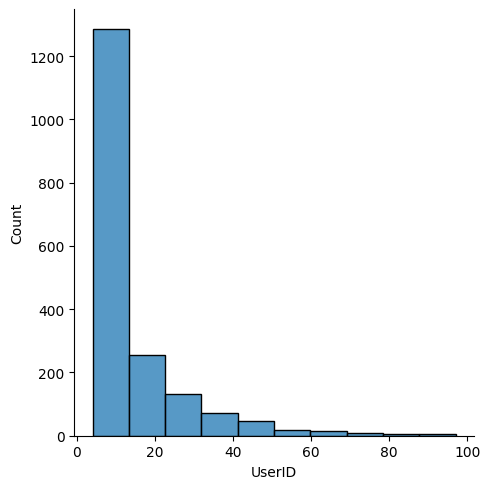

In [29]:
games_per_user = users_df['UserID'].value_counts()
sns.displot(games_per_user[(games_per_user < 100) & (games_per_user > 3)], bins=10)
plt.show()

In [30]:
avg_users = games_per_user[(games_per_user < 50) & (games_per_user > 3)].index
users_df = users_df[users_df['UserID'].isin(avg_users)]

In [31]:
user_game_matrix = users_df.pivot_table(index='UserID', columns='Name', values='Value', fill_value=0)
user_game_matrix.head()

Name,0RBITALIS,10 Second Ninja,100% Orange Juice,12 Labours of Hercules,140,15 Days,3089 -- Futuristic Action RPG,404Sight,60 Seconds!,7 Days to Die,...,iBomber Defense Pacific,iO,ibb & obb,planetarian ~the reverie of a little planet~,rFactor,rFactor 2,resident evil 4 / biohazard 4,rymdkapsel,sZone-Online,the static speaks my name
UserID,,,,,,,,,,,,,,,,,,,,,
100096071,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100311267,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100351493,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100431715,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100519466,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Para generar el sistema de recomendación, generé un modelo utilizando el algoritmo de K-Nearest-Neighbors en la matriz de usuarios y juegos. Se hace uso de una función que encuentra los 10 usuarios más cercanos a un usuario específico.

Después de esto, se hace una lista de todos los juegos jugados por usuarios parecidos, y se ordena en función de las horas jugadas. Se utiliza la matriz de similitud entre juegos para encontrar juegos que sean al menos 60% parecidos a los juegos que juegan los usuarios similares.

Por último, verifica que estos juegos encontrados no sean los mismos que le gustan al usuario original, y se hace un último filtrado, para únicamente recomendar juegos que también son similares a los que le gusta al usuario.

In [32]:
knn = NearestNeighbors(metric='cosine')
knn.fit(user_game_matrix)

NearestNeighbors(metric='cosine')

In [2]:
# Agrega un nuevo usuario a la matriz, en caso de que se quiera probar con un usuario específico
def update_user_game_matrix(user_id, new_user_df):
    global user_game_matrix
    if not {'Name', 'Value'}.issubset(new_user_df.columns):
        raise ValueError('The input DataFrame should have Name and Value columns')
    user_game_matrix = user_game_matrix.reindex(user_game_matrix.columns.union(new_user_df['Name']), axis=1, fill_value=0)
    user_game_matrix.loc[user_id] = 0
    for index, row in new_user_df.iterrows():
        user_game_matrix.at[user_id, row['Name']] = row['Value']

In [34]:
# Obtiene una lista de 10 usuarios similares al usuario al que se le busca recomendar un juego
def get_similar_users(user_id):
    global user_game_matrix
    user_data = user_game_matrix.loc[user_id].values.reshape(1, -1)
    user_data = pd.DataFrame(user_data, columns=user_game_matrix.columns)
    distances, indices = knn.kneighbors(user_data, n_neighbors=11)
    similar_users = user_game_matrix.index[indices.flatten()[1:]]

    return similar_users

In [35]:
# update_user_game_matrix('User2', new_user_df)
test_user = '100351493'
similar_users = get_similar_users(test_user)
similar_users

Index(['12259303', '151603712', '124059151', '39082468', '183337134',
       '59115473', '251635136', '58530556', '98624963', '83135348'],
      dtype='object', name='UserID')

In [36]:
similar_user_games = users_df[users_df['UserID'].isin(similar_users)].groupby('Name')['Value'].sum().sort_values(ascending=False)

In [37]:
# Obtiene una lista de juegos similares a los juegos que juegan los usuarios similares
def get_similar_games(input_games,similarity_threshold=0.6):
    global games_similarity_matrix
    similar_games = set()
    for game in input_games:
        if game in games_similarity_matrix:
            for other_game, similarity in games_similarity_matrix[game].items():
                if similarity >= similarity_threshold and other_game not in input_games:
                    similar_games.add(other_game)

    return list(similar_games)

In [38]:
games_from_similar_users = get_similar_games(similar_user_games.index[:10])

In [39]:
games_liked_by_user = user_game_matrix.loc[test_user][user_game_matrix.loc[test_user] > 0].index.tolist()

In [45]:
# Verifica que los juegos recomendados por otros usuarios sean similares a los gustos del usuario
def verify_game_similarity(list1, list2, similarity_threshold=0.6):
    global games_similarity_matrix
    similar_games = []

    for game1 in list1:
        if game1 in games_similarity_matrix.index.tolist() and game1 not in list2:
            for game2 in list2:
                if game2 in games_similarity_matrix.columns.tolist():
                    similarity = games_similarity_matrix.loc[game1, game2]
                    if similarity >= similarity_threshold:
                        similar_games.append((game1, game2, similarity))

    return similar_games

Para evaluar el sistema de recomendación, se utiliza una función que toma como parámetro una lista de usuarios (1000 en este caso).

La función aplica todos los pasos para cada uno de los usuarios. Considero que un buen sistema de recomendación debería ser capaz de recomendar mínimo un juego por cada dos juegos que un usuario juegue. Por ejemplo, si un usuario juega 100 juegos, el sistema debería ser capaz de hacer mínimo 50 recomendaciones exitosas.

La función definida tiene como salida un valor numérico que indica el porcentaje de usuarios a los que se les recomendó al menos un juego por cada dos juegos jugados.

Utilizando una muestra aleatoria de 1000 usuarios, el sistema pudo pasar este filtro en el 86.5% de los casos, por lo que considero que cumple con su función.

In [48]:
test_users = random.sample(users_df['UserID'].unique().tolist(), 1000)

In [44]:
def validate_recommendations(test_users):
    successful_users_count = 0
    total_users = len(test_users)

    for user in test_users:
        similar_users = get_similar_users(user)
        similar_user_games = users_df[users_df['UserID'].isin(similar_users)].groupby('Name')['Value'].sum().sort_values(ascending=False)
        games_from_similar_users = get_similar_games(similar_user_games.index[:10])
        games_liked_by_user = user_game_matrix.loc[user][user_game_matrix.loc[user] > 0].index.tolist()
        number_of_games_liked_by_user = len(games_liked_by_user)
        number_of_successful_recommendations = len(verify_game_similarity(games_from_similar_users, games_liked_by_user))

        if number_of_successful_recommendations >= number_of_games_liked_by_user / 5:
            successful_users_count += 1

    percentage_of_successful_users = (successful_users_count / total_users) * 100
    return percentage_of_successful_users

In [49]:
percentage_of_success = validate_recommendations(test_users)
print(f"{percentage_of_success}% of users were recommended at least one game for every 2 games they played")

86.5% of users were recommended at least one game for every 2 games they played


Considero que, a pesar de que el algoritmo cumple con su función en la mayoría de los casos, podría ser fácilmente mejorado si más información estuviese disponible.

Por ejemplo, en la versión actual, se utiliza el número de horas jugadas en un juego para definir si a un usuario le gusta o no. Esta métrica puede ser un buen indicador, ya que, si un usuario juega mucho un juego, muy probablemente le guste. Sin embargo, esto asume que al usuario le gustan todos los juegos que ha jugado.

Si además de las horas jugadas, se contara con un rating de los usuarios hacia los juegos, se le podría aplicar una penalización a los juegos que el usuario jugó pero le dió un rating bajo, o incluso darle prioridad a buscar juegos similares a aquellos que el usuario le dió un rating muy algo.

También sería útil contar con más información acerca de los desarrolladores. Por ejemplo, algunos jugadores suelen jugar juegos de estudios muy grandes, mientras que otros prefieren jugar juegos "indie", de desarrolladores más pequeños. Clasificar a los usuarios en base a esto antes de aplicar el algoritmo KNN puede hacer más claras las similitudes entre los usuarios.